## Data visualization

In [56]:
# read data and remove duplicating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df= pd.read_csv('BTC-Daily.csv')
df.drop_duplicates

# convert date column
df['date'] = pd.to_datetime(df['date'])
date_range = str(df['date'].dt.date.min()) + ' to ' + str(df['date'].dt.date.max())
unique_years = df['date'].dt.year.unique()

In [57]:
# creare a new column year, month, day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

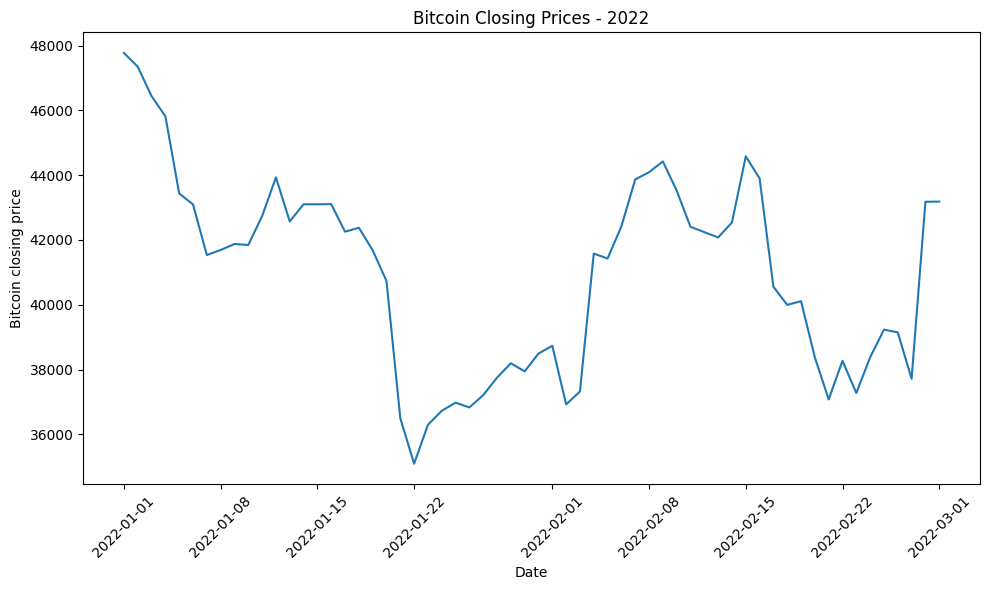

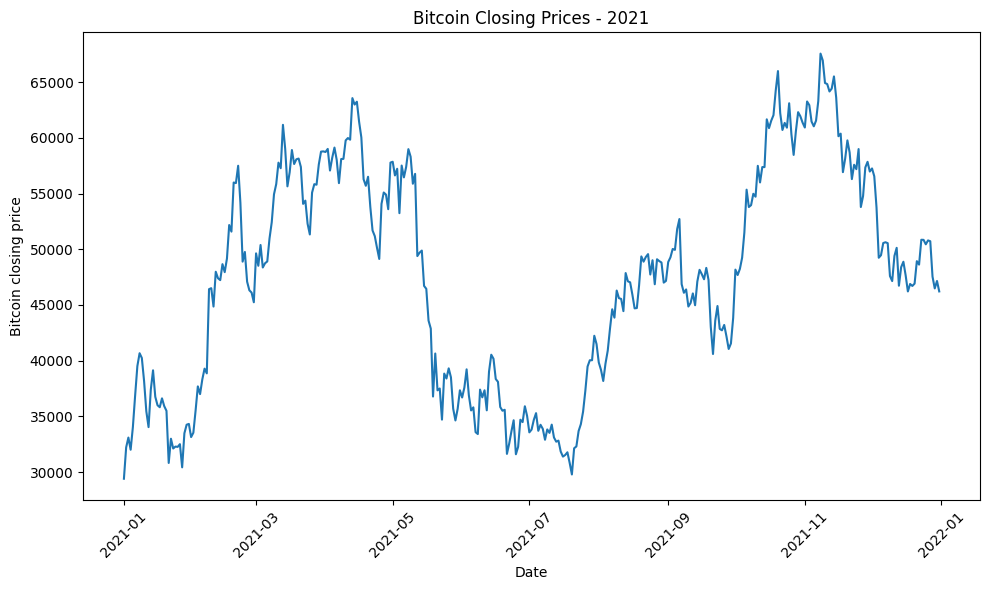

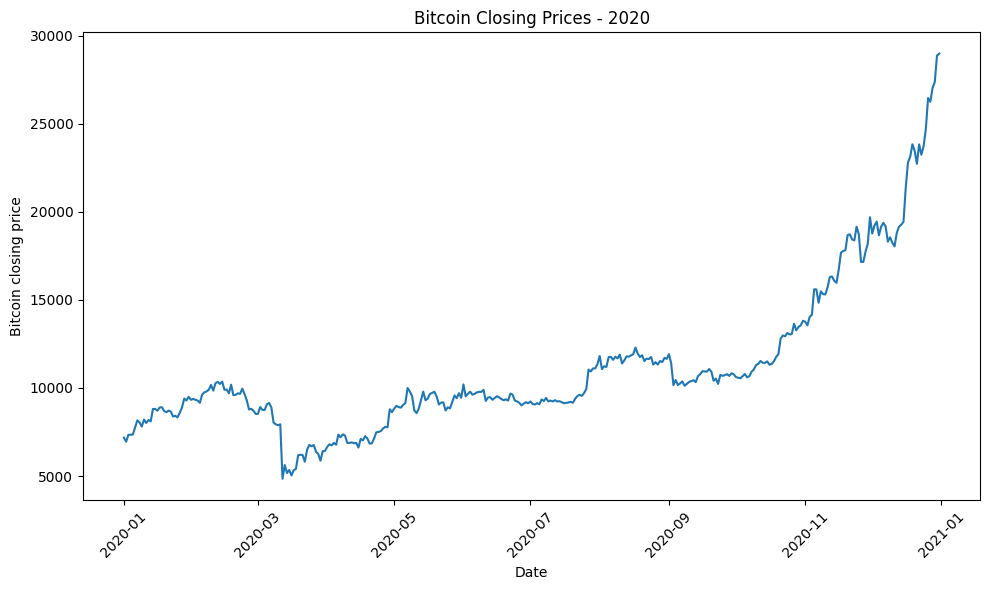

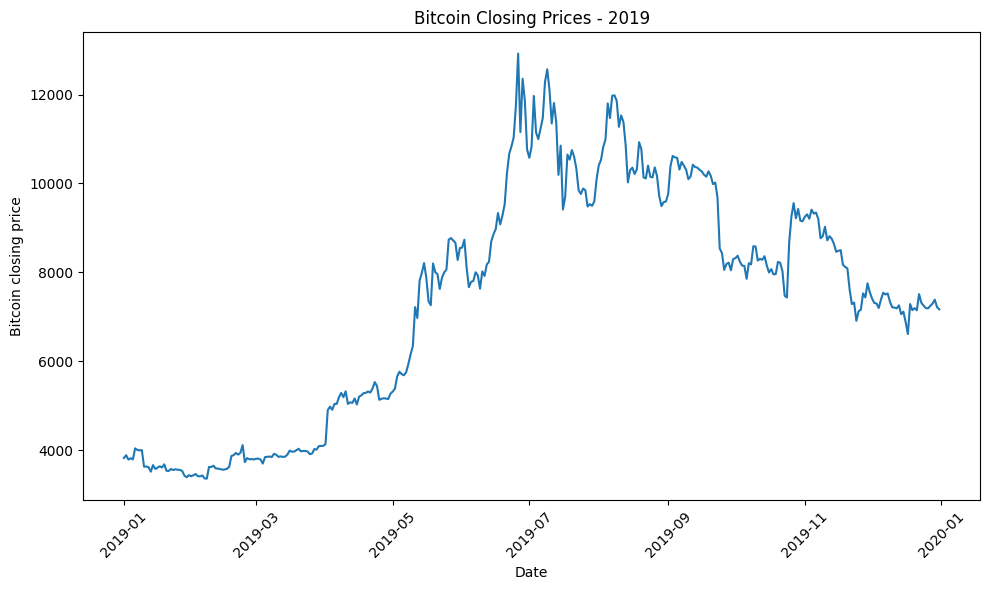

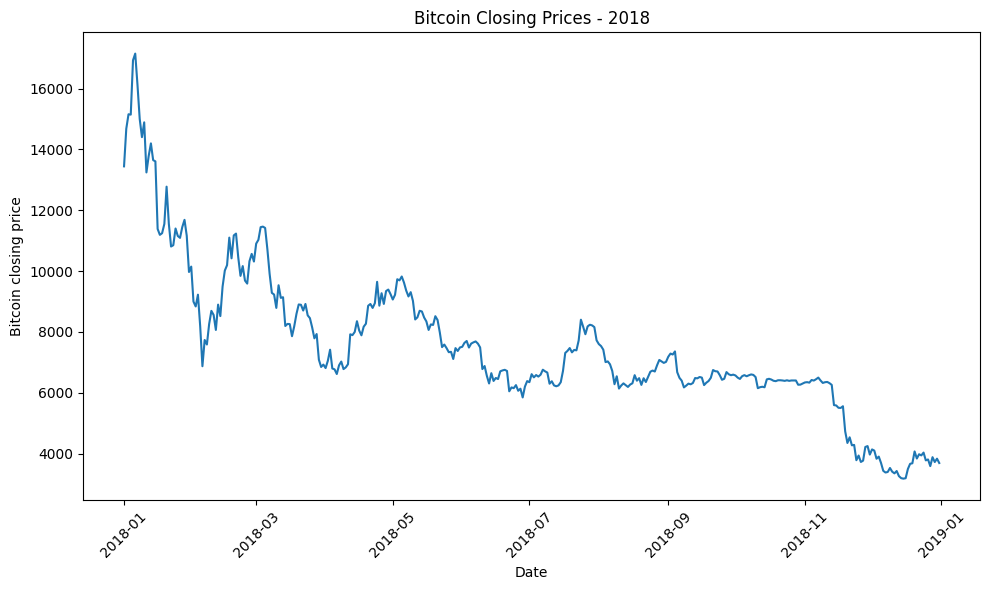

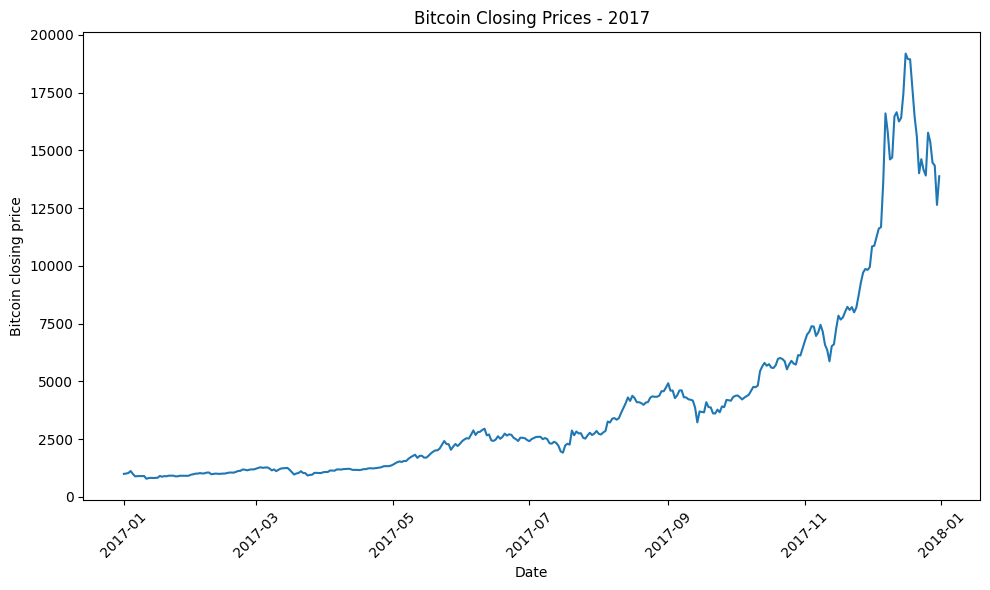

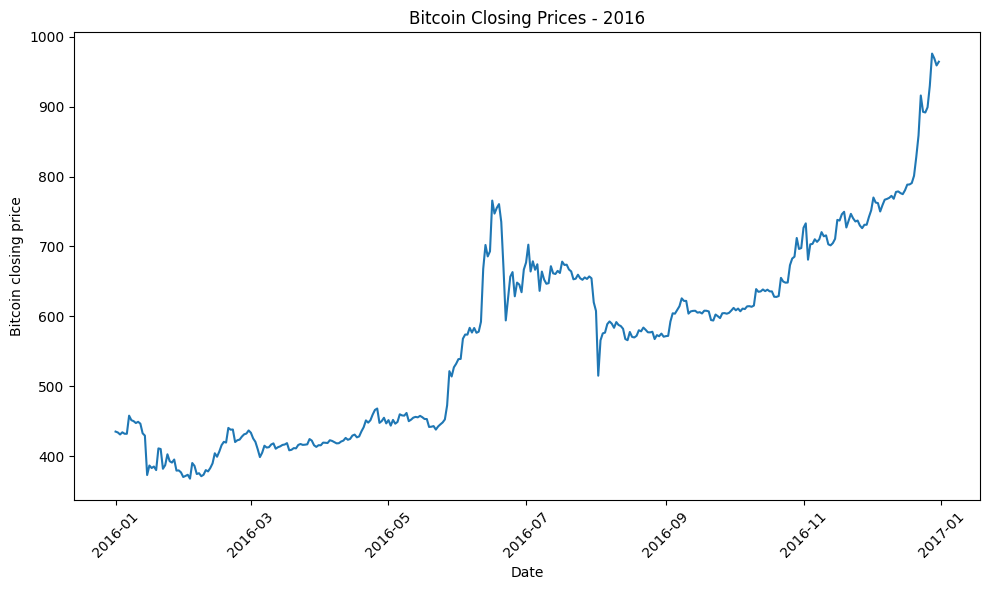

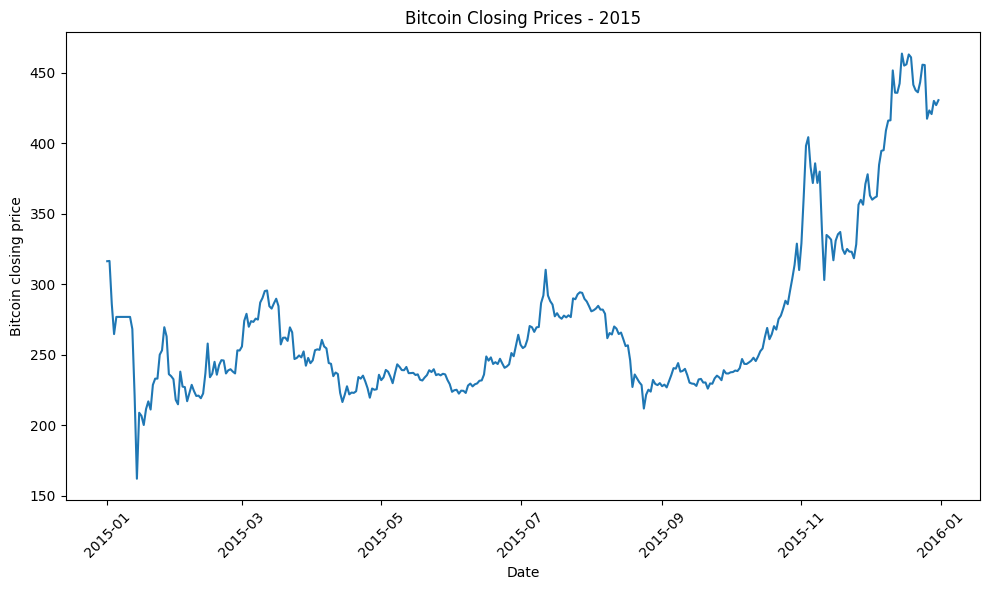

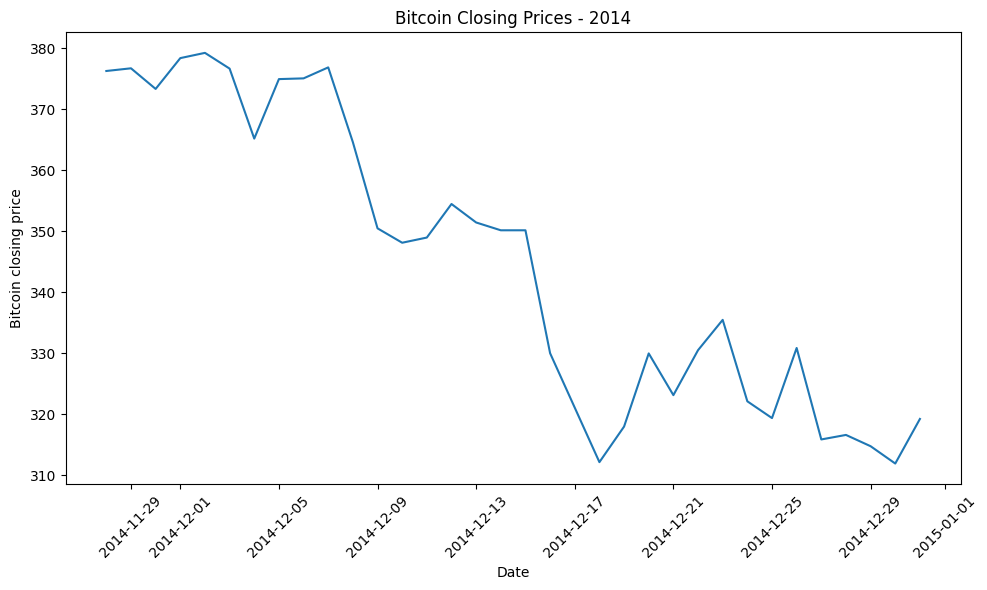

In [58]:
for year in unique_years:
    # create a dataframe of date
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
    year_month_day = pd.DataFrame({'date': dates})
    year_month_day['year'] = year_month_day['date'].dt.year
    year_month_day['month'] = year_month_day['date'].dt.month
    year_month_day['day'] = year_month_day['date'].dt.day

    merged_data = pd.merge(year_month_day, df, on=['year', 'month', 'day'], how= 'left', validate="many_to_many")

    plt.figure(figsize=(10,6))
    plt.plot(merged_data['date_x'], merged_data['close'])
    plt.title(f'Bitcoin Closing Prices - { year }')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin closing price')
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

               


C:\Users\lamxu\AppData\Local\Temp\ipykernel_1992\1316288193.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].map(mdates.date2num)


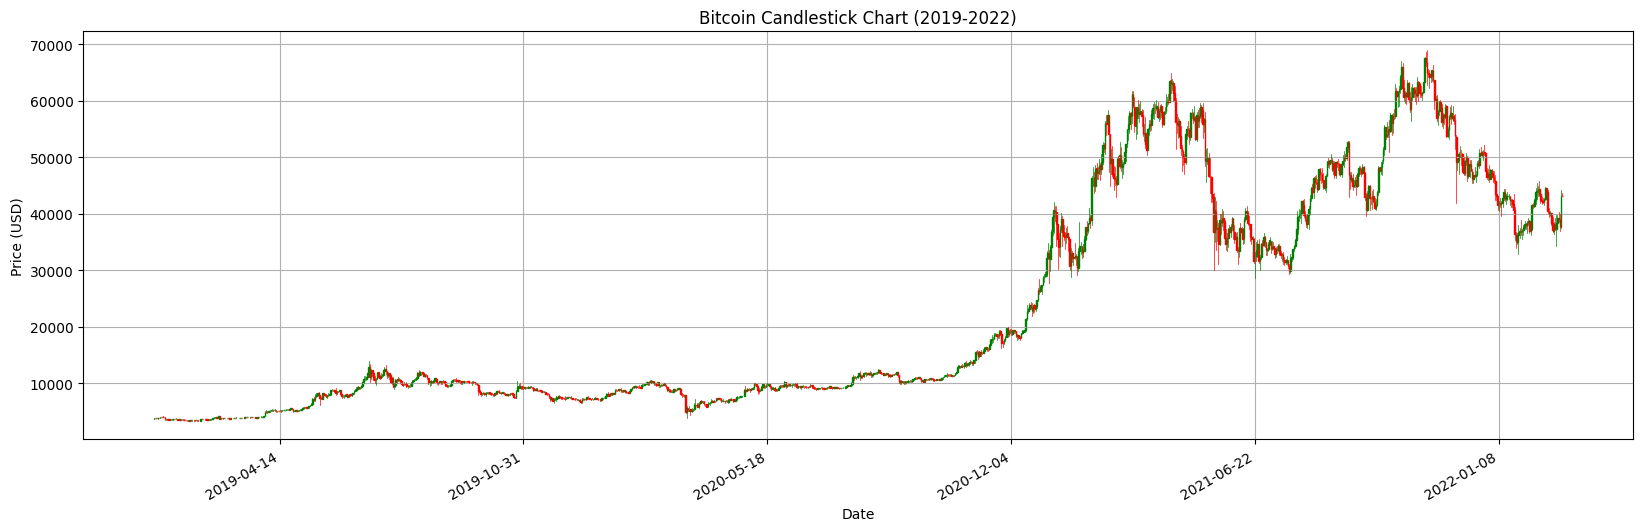

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime

# Filter data for 2019-2022
df_filtered = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2022-12-31')]

# Convert date to matplotlib format
df_filtered['date'] = df_filtered['date'].map(mdates.date2num)

# Create the candlestick chart
fig, ax = plt.subplots(figsize=(20, 6))

candlestick_ohlc(ax, df_filtered[['date', 'open', 'high', 'low', 'close']].values, width=0.6, colorup='g', colordown='r')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.title('Bitcoin Candlestick Chart (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)

# Save the plot as a PDF
plt.savefig('bitcoin_candlestick_2019_2022.pdf')

plt.show()

## build a model

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# data standardization
scalar = StandardScaler()

df["Standardized_Close_Prices"] = scalar.fit_transform(df['close'].values.reshape(-1,1))
df["Standardized_open_Prices"] = scalar.fit_transform(df['open'].values.reshape(-1,1))
df["Standardized_high_Prices"] = scalar.fit_transform(df['high'].values.reshape(-1,1))
df["Standardized_low_Prices"] = scalar.fit_transform(df['low'].values.reshape(-1,1))

In [61]:
X = df[['Standardized_open_Prices', 'Standardized_high_Prices', 'Standardized_low_Prices']]
y = df['Standardized_Close_Prices']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [62]:
def predict(x, w, b):
    return x.dot(w.T) + b

def gradient(y_hat, x, y):
    loss = y_hat-y
    dw = x.T.dot(loss)/len(y)
    db = np.sum(loss)/len(y)
    cost = np.sum(loss**2)/(2*len(y))
    return dw, db, cost

def update_weight(w, b, dw, db, lr):
    new_w = w - lr*dw
    new_b = b - lr*db
    return new_w, new_b

In [63]:
def linear_regression_vectorized(x,y, lr,eporches = 200):
    _, n_features = x.shape
    w = np.zeros(n_features)
    b = 0
    losses = []

    for _ in range(eporches):
        y_hat = predict(x=x,w=w,b=b)
        dw, db, cost = gradient(y_hat=y_hat, y=y, x=x)
        w, b = update_weight(w=w, b=b, dw=dw, db=db, lr=lr)
        losses.append(cost)
    return w, b, losses

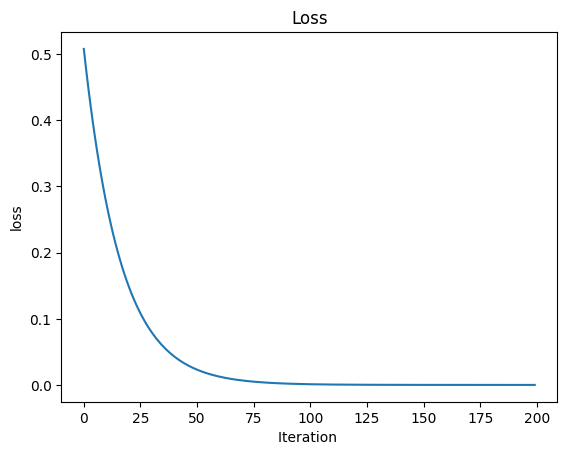

In [64]:
w, b, losses = linear_regression_vectorized ( X_train.values , y_train.values ,lr =0.01 , eporches =200)
plt.plot(losses)
plt.xlabel('Iteration ')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

In [65]:
# valuate training data
y_pred = predict(X_test,w,b)


In [66]:
from sklearn . metrics import r2_score
# calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE',rmse)

# calculate MAE
mae = np.mean(np.abs(y_pred - y_test))
print('mae',mae)

# Calculate R- squared on training data
y_train_pred = predict ( X_train , w, b)
train_accuracy = r2_score ( y_train , y_train_pred )

# Calculate R- squared on testing data
test_accuracy = r2_score (y_test , y_pred )
print('train_accuracy',train_accuracy)
print('test_accuracy',test_accuracy)

RMSE 0.026284088880714117
mae 0.012724208541726224
train_accuracy 0.9989052830615972
test_accuracy 0.9992644648953711


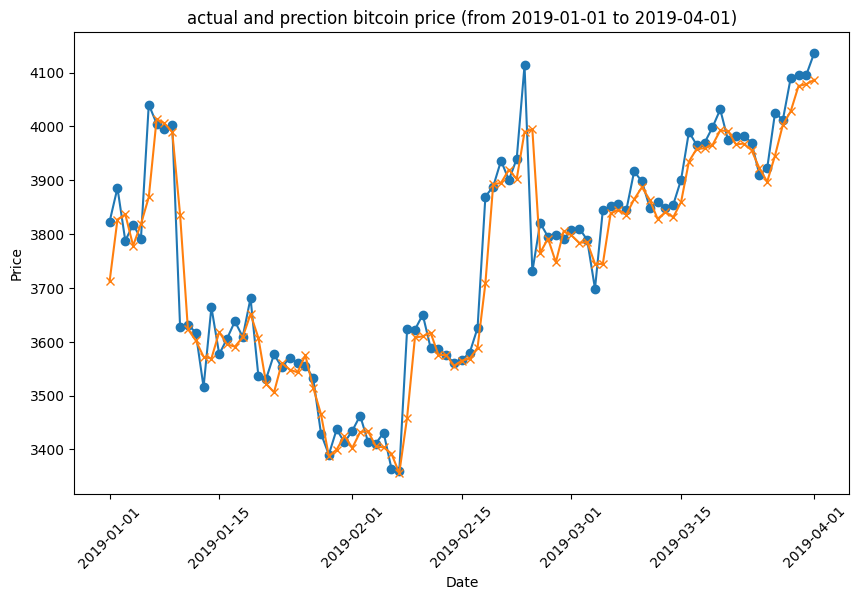

In [67]:
# Filter data for 2019 -01 -01 to 2019 -04 -01
df_2019_q1 = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2019-04-01')]

# actual X, y data
X_2019_q1 = df_2019_q1[['open', 'high', 'low']]
y_2019_q1_actual = df_2019_q1['close']

# predict data
y_2019_q1_pred = predict(X_2019_q1, w,b)
plt.figure(figsize=(10,6))
plt.plot(df_2019_q1['date'] ,y_2019_q1_actual, label = 'actual close price', marker ='o')
plt.plot(df_2019_q1['date'] ,y_2019_q1_pred, label = 'predicted close price', marker ='x')
plt.title('actual and prection bitcoin price (from 2019-01-01 to 2019-04-01)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

